In [1]:
from chromatic_fitting import *
import corner
import starry 
starry.config.lazy = True
starry.config.quiet = True
import theano
theano.config.gcc__cxxflags += " -fexceptions"

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Running chromatic_fitting v0.11.1!

This program is running on:
Python v3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]
numpy v1.21.6
chromatic v0.4.6
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


In [123]:
star_params = dict(
    ydeg=10,  # degree of the map
    udeg=2,  # degree of the limb darkening
    inc=90,  # inclination in degrees
    amp=1.0,  # amplitude (a value prop. to luminosity)
    r=0.3,  #  radius in R_sun
    m=0.3,  # mass in M_sun
    prot=5,  # rotational period (d)
    u=[0.10, 0.10],  # limb darkening coefficients
)

planet_params = dict(
    porb=30, # orbital period of planet (d)
    mp=4, # mass of planet in M_earth
    rp=5, # radius of planet in R_earth
    ecc=0.1, # eccentricity
    omega=180, # longitude of ascending node in degrees
)

In [124]:
with pm.Model() as model:

    # Primary
    star = starry.Primary(
        starry.Map(ydeg=star_params["ydeg"], udeg=star_params["udeg"], amp=star_params['amp'], inc=80, obl=10),
        r=star_params["r"],
        m=star_params["m"],
        prot=star_params["prot"],
        length_unit=u.R_sun,
        mass_unit=u.M_sun,
    )
    star.map[1:] = star_params["u"]
    
    # Add some spots
    star.map.spot(contrast=0.5, radius=20, lat=0, lon=15)
    star.map.spot(contrast=0.5, radius=30, lat=40, lon=-40)
    
    # Secondary (planet)
    planet = starry.kepler.Secondary(
    starry.Map(ydeg=10, amp=5e-3),  # the surface map
    m=planet_params['mp'],  # mass in solar masses
    r=planet_params['rp'],# radius
    inc=star_params["inc"],
    length_unit=u.R_earth,
    mass_unit=u.M_earth,
    porb=planet_params['porb'],  # orbital period in days
    prot=planet_params['porb'],  # rotation period in days (synchronous)
    omega=planet_params['omega'],  # longitude of ascending node in degrees
    ecc=planet_params['ecc'],  # eccentricity
    t0=0,  # time of transit in days
    )

    # System
    sys = starry.System(star, planet)

In [125]:
star.map.show(theta=np.linspace(0,2*np.pi,100))

In [126]:
sys.show(t=np.linspace(-1,1,100))

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0


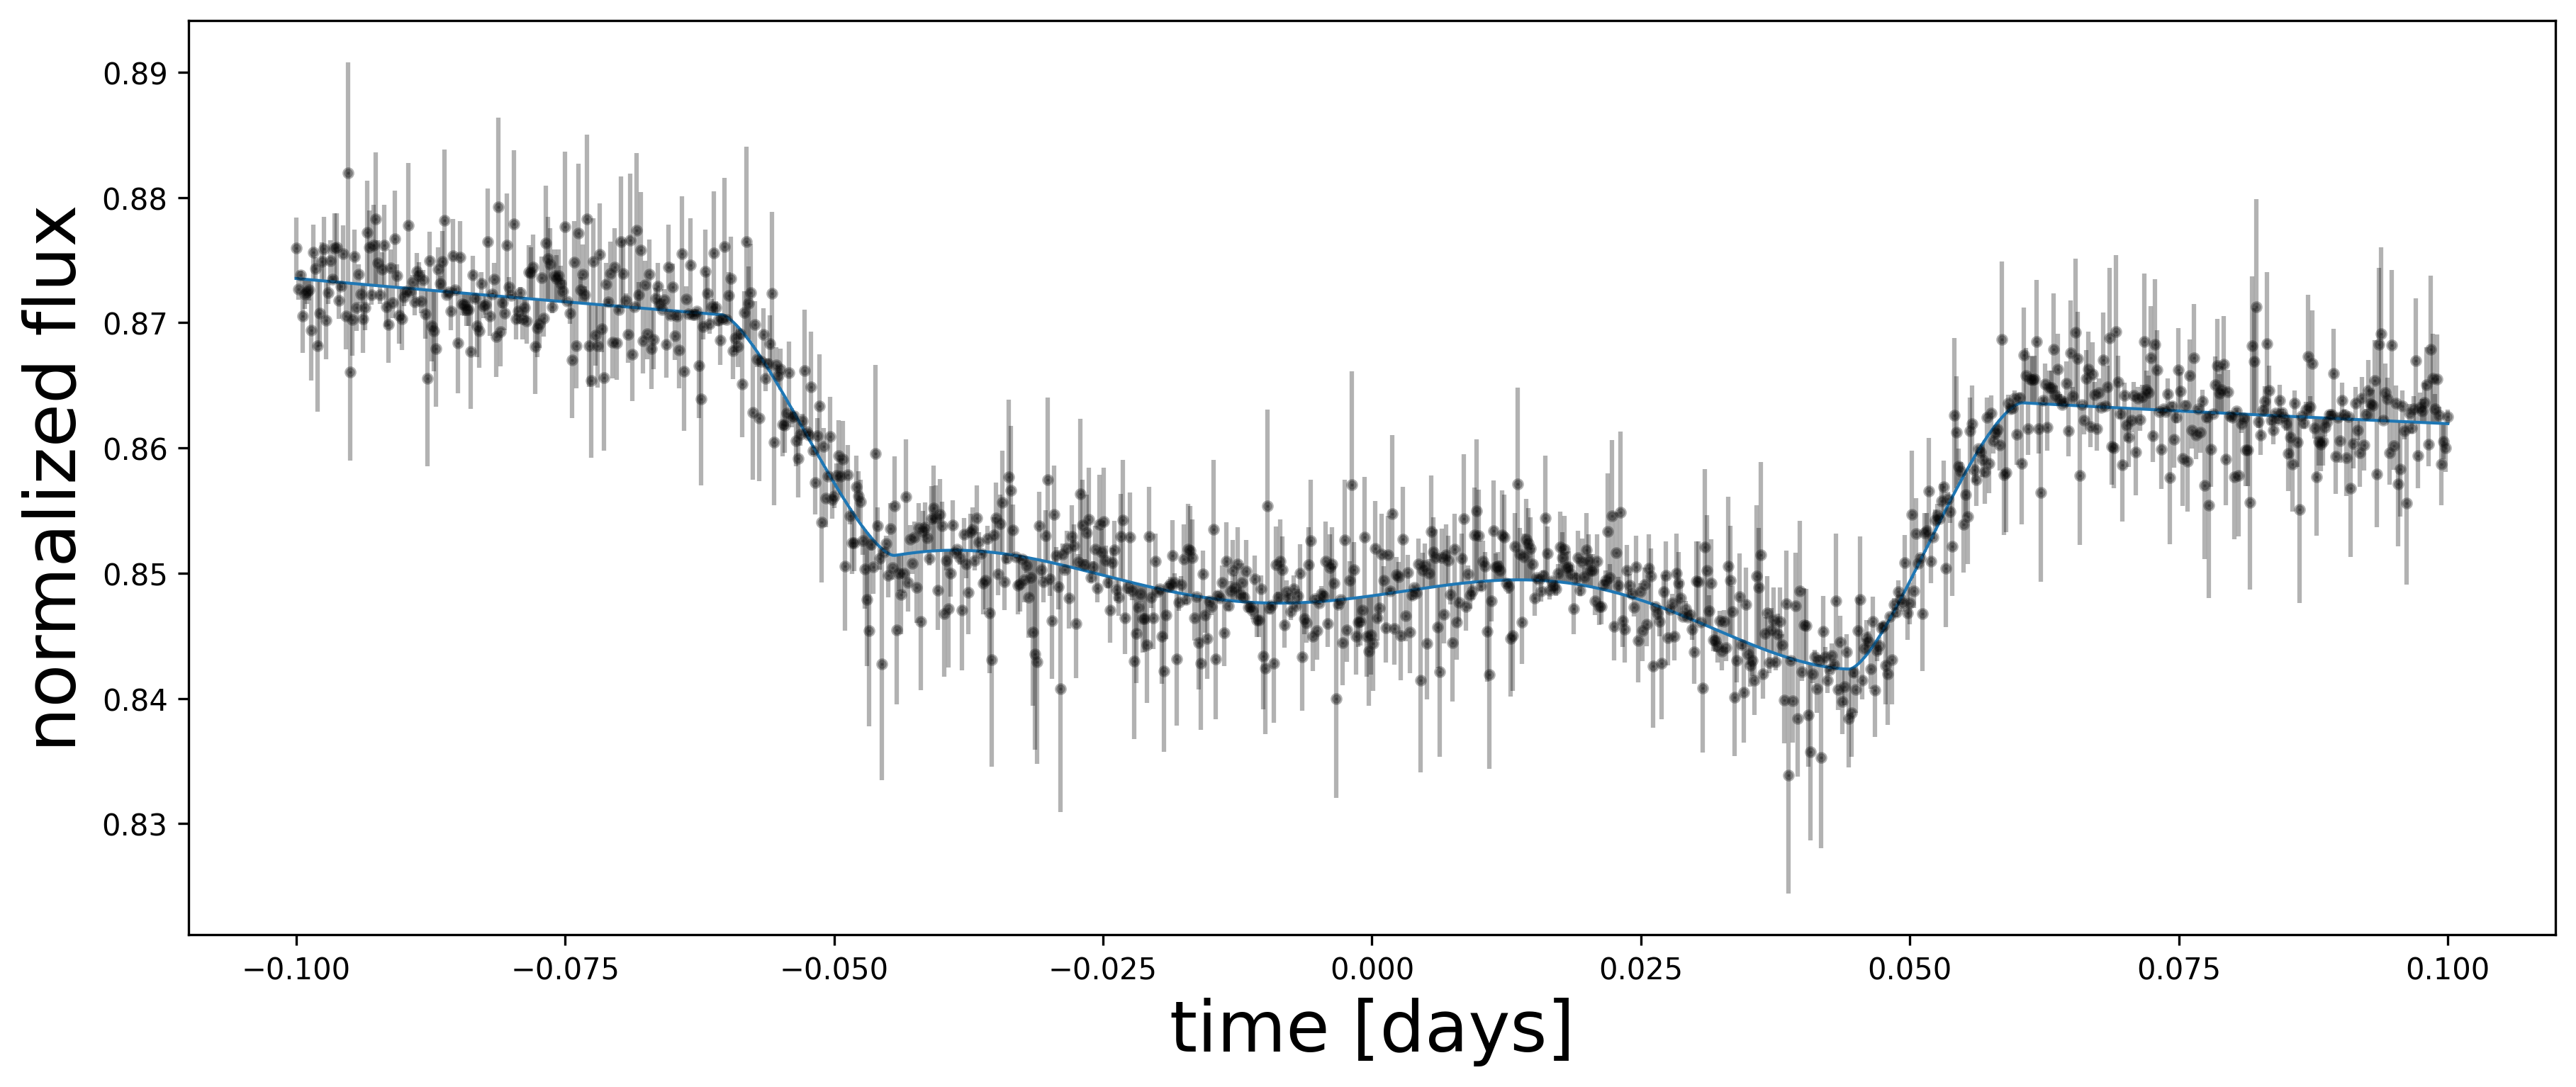

In [127]:
t = np.linspace(-0.1, 0.1, 1000)
flux_true = eval_in_model(sys.flux(t), model=model)
sigma = 3e-3
ferr = sigma * np.random.randn(len(t))
flux = flux_true + ferr

fig, ax = plt.subplots(1, figsize=(12, 5))
ax.plot(t, flux, "k.", alpha=0.3, ms=2)
plt.errorbar(t, flux, np.abs(ferr), c="k", fmt='.', alpha=0.3)
ax.plot(t, flux_true, lw=1)
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24);

<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='Wavelength ($\\mathrm{\\mu m}$)'>

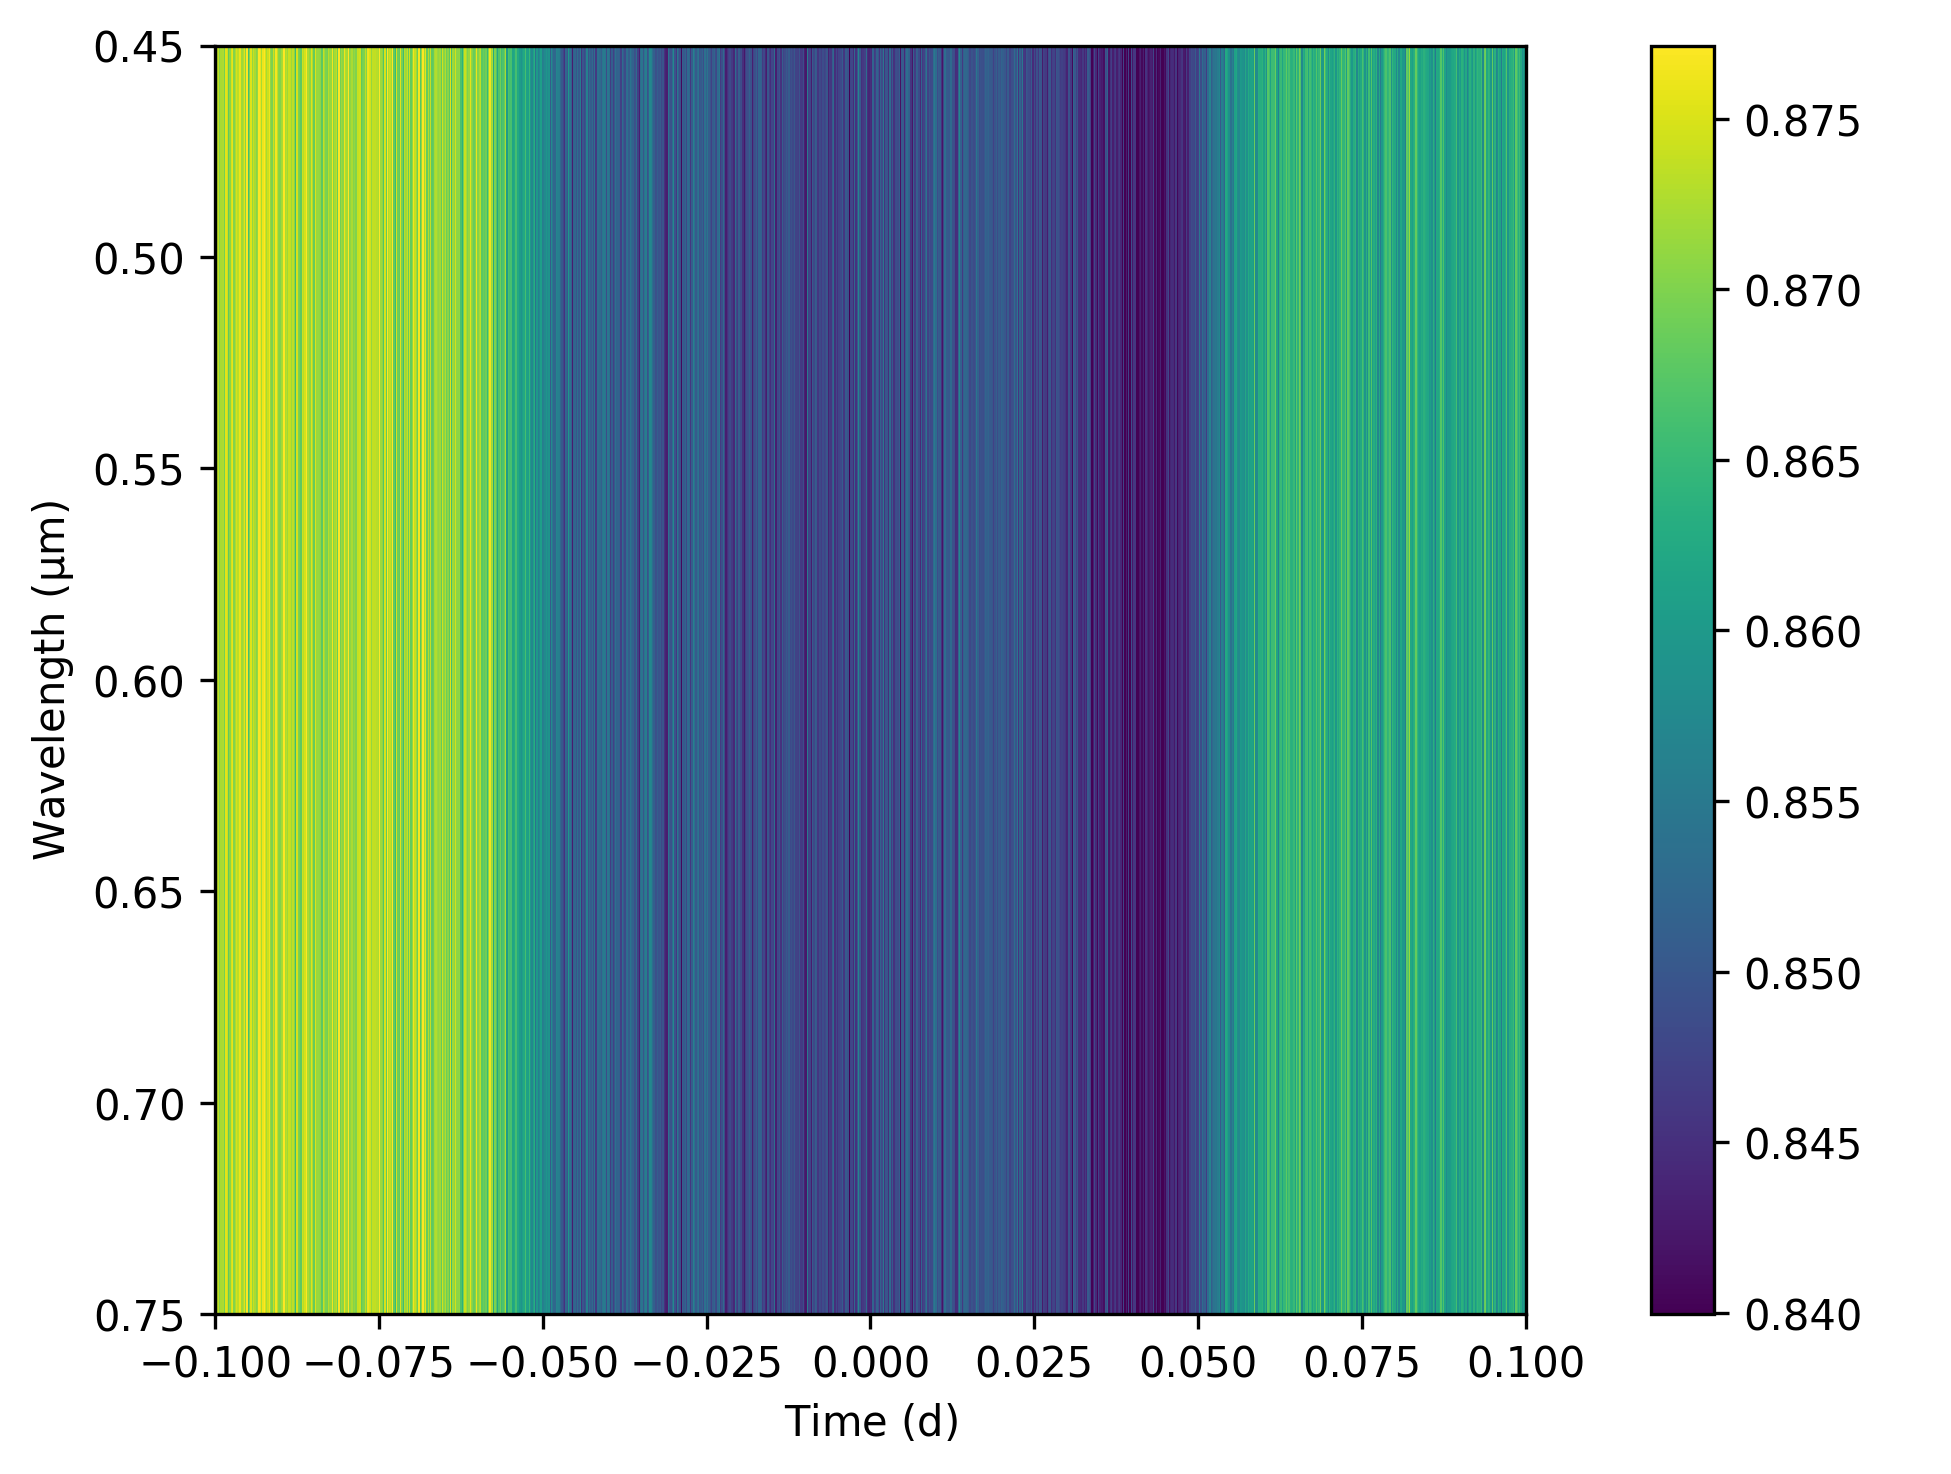

In [128]:
r = SimulatedRainbow(time=t*u.d, wavelength=[0.5,0.6,0.7]*u.micron)
r.flux[:,:] = flux
r.uncertainty[:,:] = ferr
r.imshow()

In [129]:
s = TransitSpotModel(ydeg=star_params['ydeg'], nspots=2)
s.setup_parameters(
    A = Fitted(Normal, mu=1, sd=0.1),
    
    # stellar parameters
    rs=star_params["r"], # stellar radius in Sun radius
    ms=star_params["m"], # stellar mass in Sun masses
    prot=star_params["prot"], # stellar rotation period
    u=WavelikeFitted(Uniform, lower=[0.0,0.0], upper=[1.0,1.0], testval=[0.25,0.29], shape=2), # limb-darkening coeffs
    stellar_inc = 80,
    stellar_obl = 10,
    
    # spot 1 parameters
    spot_1_contrast = 0.5, #WavelikeFitted(Uniform,lower=0.0, upper=1.0, testval=0.5),
    spot_1_radius = Fitted(Uniform,lower=10.0, upper=50, testval=15.0),
    spot_1_latitude = Fitted(Uniform, lower=-45, upper=45, testval=-10.0),
    spot_1_longitude = Fitted(Uniform, lower=0, upper=60, testval=10.0),
    
    # spot 2 parameters
    spot_2_contrast = 0.5, #WavelikeFitted(Uniform,lower=0.0, upper=1.0, testval=0.5),
    spot_2_radius = Fitted(Uniform,lower=10.0, upper=50, testval=15.0),
    spot_2_latitude = Fitted(Uniform, lower=-45, upper=45, testval=10.0),
    spot_2_longitude = Fitted(Uniform, lower=-80, upper=-10, testval=-30.0),
    
    # planet parameters
    mp=planet_params['mp'], # planet mass in Earth masses
    rp=WavelikeFitted(Normal, mu=planet_params['rp'], sigma=0.1), # planet radius in Earth radii
    inc=star_params["inc"],
    period=planet_params['porb'],  # orbital period in days
    omega=planet_params['omega'],  # longitude of ascending node in degrees
    ecc=planet_params['ecc'],  # eccentricity
    t0=Fitted(Normal, mu=0, sigma=0.05) # time of transit in days
)

In [130]:
s.summarize_parameters()

transitspot_A =
  <🧮 Fitted Normal(mu=1, sd=0.1, name='transitspot_A') 🧮>

transitspot_rs =
  <🧮 Fixed | 0.3 🧮>

transitspot_ms =
  <🧮 Fixed | 0.3 🧮>

transitspot_stellar_amp =
  <🧮 Fixed | 1 🧮>

transitspot_stellar_inc =
  <🧮 Fixed | 80 🧮>

transitspot_stellar_obl =
  <🧮 Fixed | 10 🧮>

transitspot_prot =
  <🧮 Fixed | 5 🧮>

transitspot_u =
  <🧮 WavelikeFitted Uniform(lower=[0.0, 0.0], upper=[1.0, 1.0], testval=[0.25, 0.29], shape=2, name='transitspot_u') for each wavelength 🧮>

transitspot_mp =
  <🧮 Fixed | 4 🧮>

transitspot_rp =
  <🧮 WavelikeFitted Normal(mu=5, sigma=0.1, name='transitspot_rp') for each wavelength 🧮>

transitspot_inc =
  <🧮 Fixed | 90 🧮>

transitspot_amp =
  <🧮 Fixed | 0.005 🧮>

transitspot_period =
  <🧮 Fixed | 30 🧮>

transitspot_omega =
  <🧮 Fixed | 180 🧮>

transitspot_ecc =
  <🧮 Fixed | 0.1 🧮>

transitspot_t0 =
  <🧮 Fitted Normal(mu=0, sigma=0.05, name='transitspot_t0') 🧮>

transitspot_spot_1_contrast =
  <🧮 Fixed | 0.5 🧮>

transitspot_spot_1_radius =
  <🧮 Fitted U

In [131]:
s.attach_data(r.normalize().bin(ntimes=2))
s.choose_optimization_method("white_light")
s.setup_likelihood()

  0%|          | 0/3 [00:00<?, ?it/s]

.setup_lightcurves() has not been run yet, running now...


  0%|          | 0/500 [00:00<?, ?it/s]

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (the

message: Desired error not necessarily achieved due to precision loss.
logp: -40533096590.0499 -> 2554.061274713224
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano

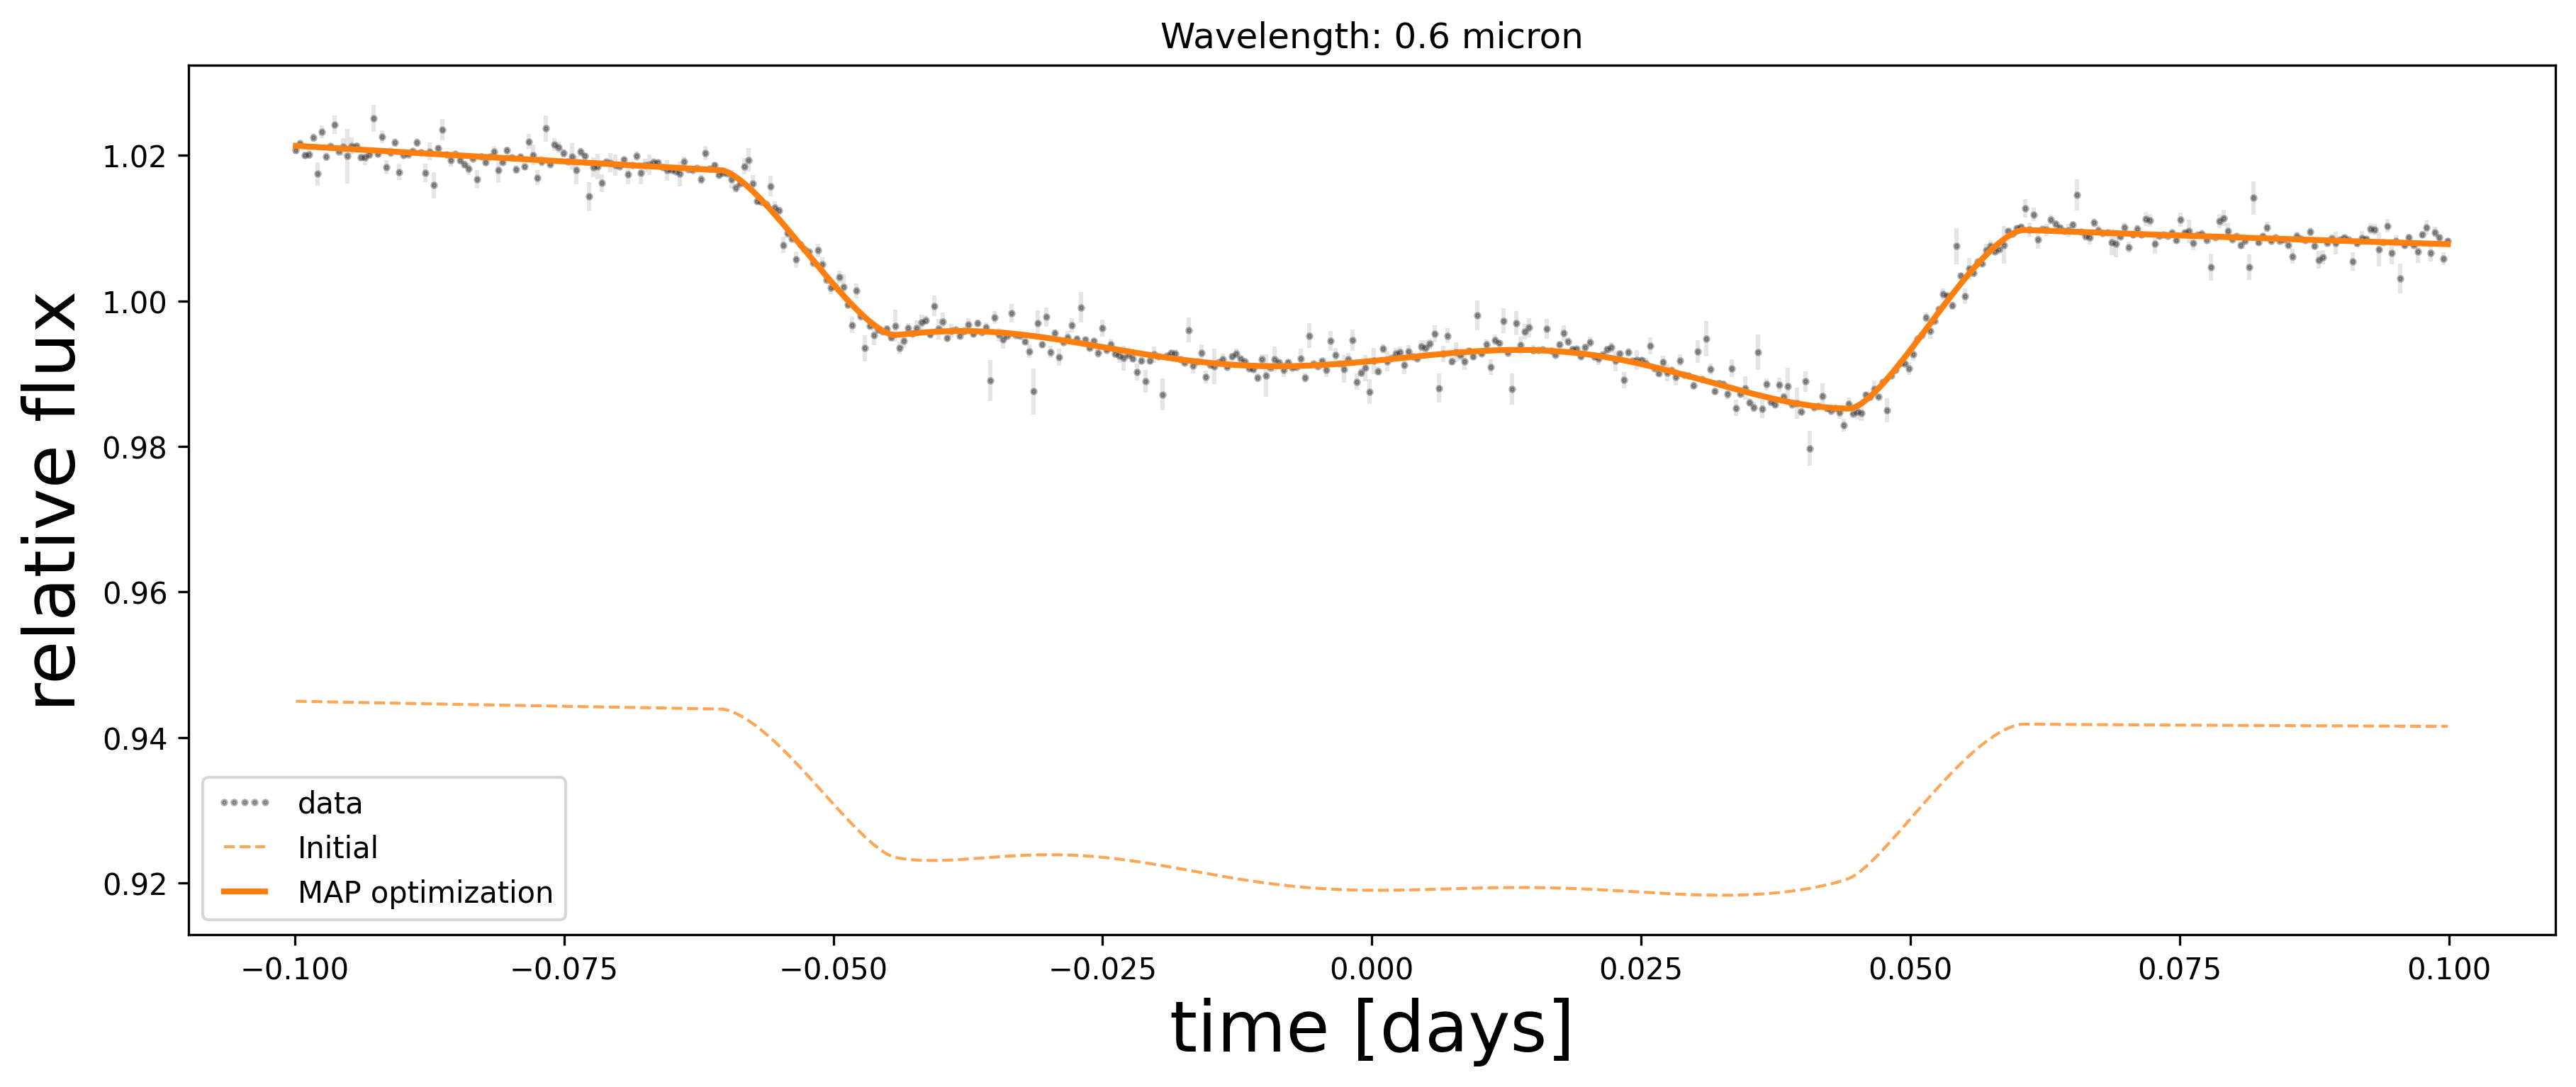

In [132]:
opt=s.optimize(plot=True)

In [135]:
s.sample(start=opt, sampling_method=pmx.sample, draws=200, tune=200, chains=1, cores=1)

Sampling model using the <function sample at 0x291ae8430> method


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (the

Sampling 1 chain for 200 tune and 200 draw iterations (200 + 200 draws total) took 50845 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cann

                                      mean        sd    hdi_16%    hdi_84%  \
transitspot_A[0]                  1.143495  0.000514   1.143069   1.144076   
transitspot_rp[0]                 5.012466  0.002675   5.009395   5.014449   
transitspot_t0[0]                 0.000069  0.000013   0.000056   0.000082   
transitspot_u[0, 0]               0.049579  0.003073   0.046439   0.052468   
transitspot_u[0, 1]               0.158935  0.005885   0.152640   0.164727   
transitspot_spot_1_radius[0]     19.739083  0.083206  19.655970  19.822054   
transitspot_spot_1_latitude[0]   -1.226105  0.221201  -1.480924  -1.078405   
transitspot_spot_1_longitude[0]  14.383871  0.066729  14.331256  14.460290   
transitspot_spot_2_radius[0]     25.786229  0.032095  25.747460  25.809776   
transitspot_spot_2_latitude[0]   -7.824339  0.149756  -7.997049  -7.712934   
transitspot_spot_2_longitude[0] -40.386330  0.114612 -40.519810 -40.288623   

                                 mcse_mean   mcse_sd    ess_bul

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0


<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='Relative Flux (+ offsets)'>

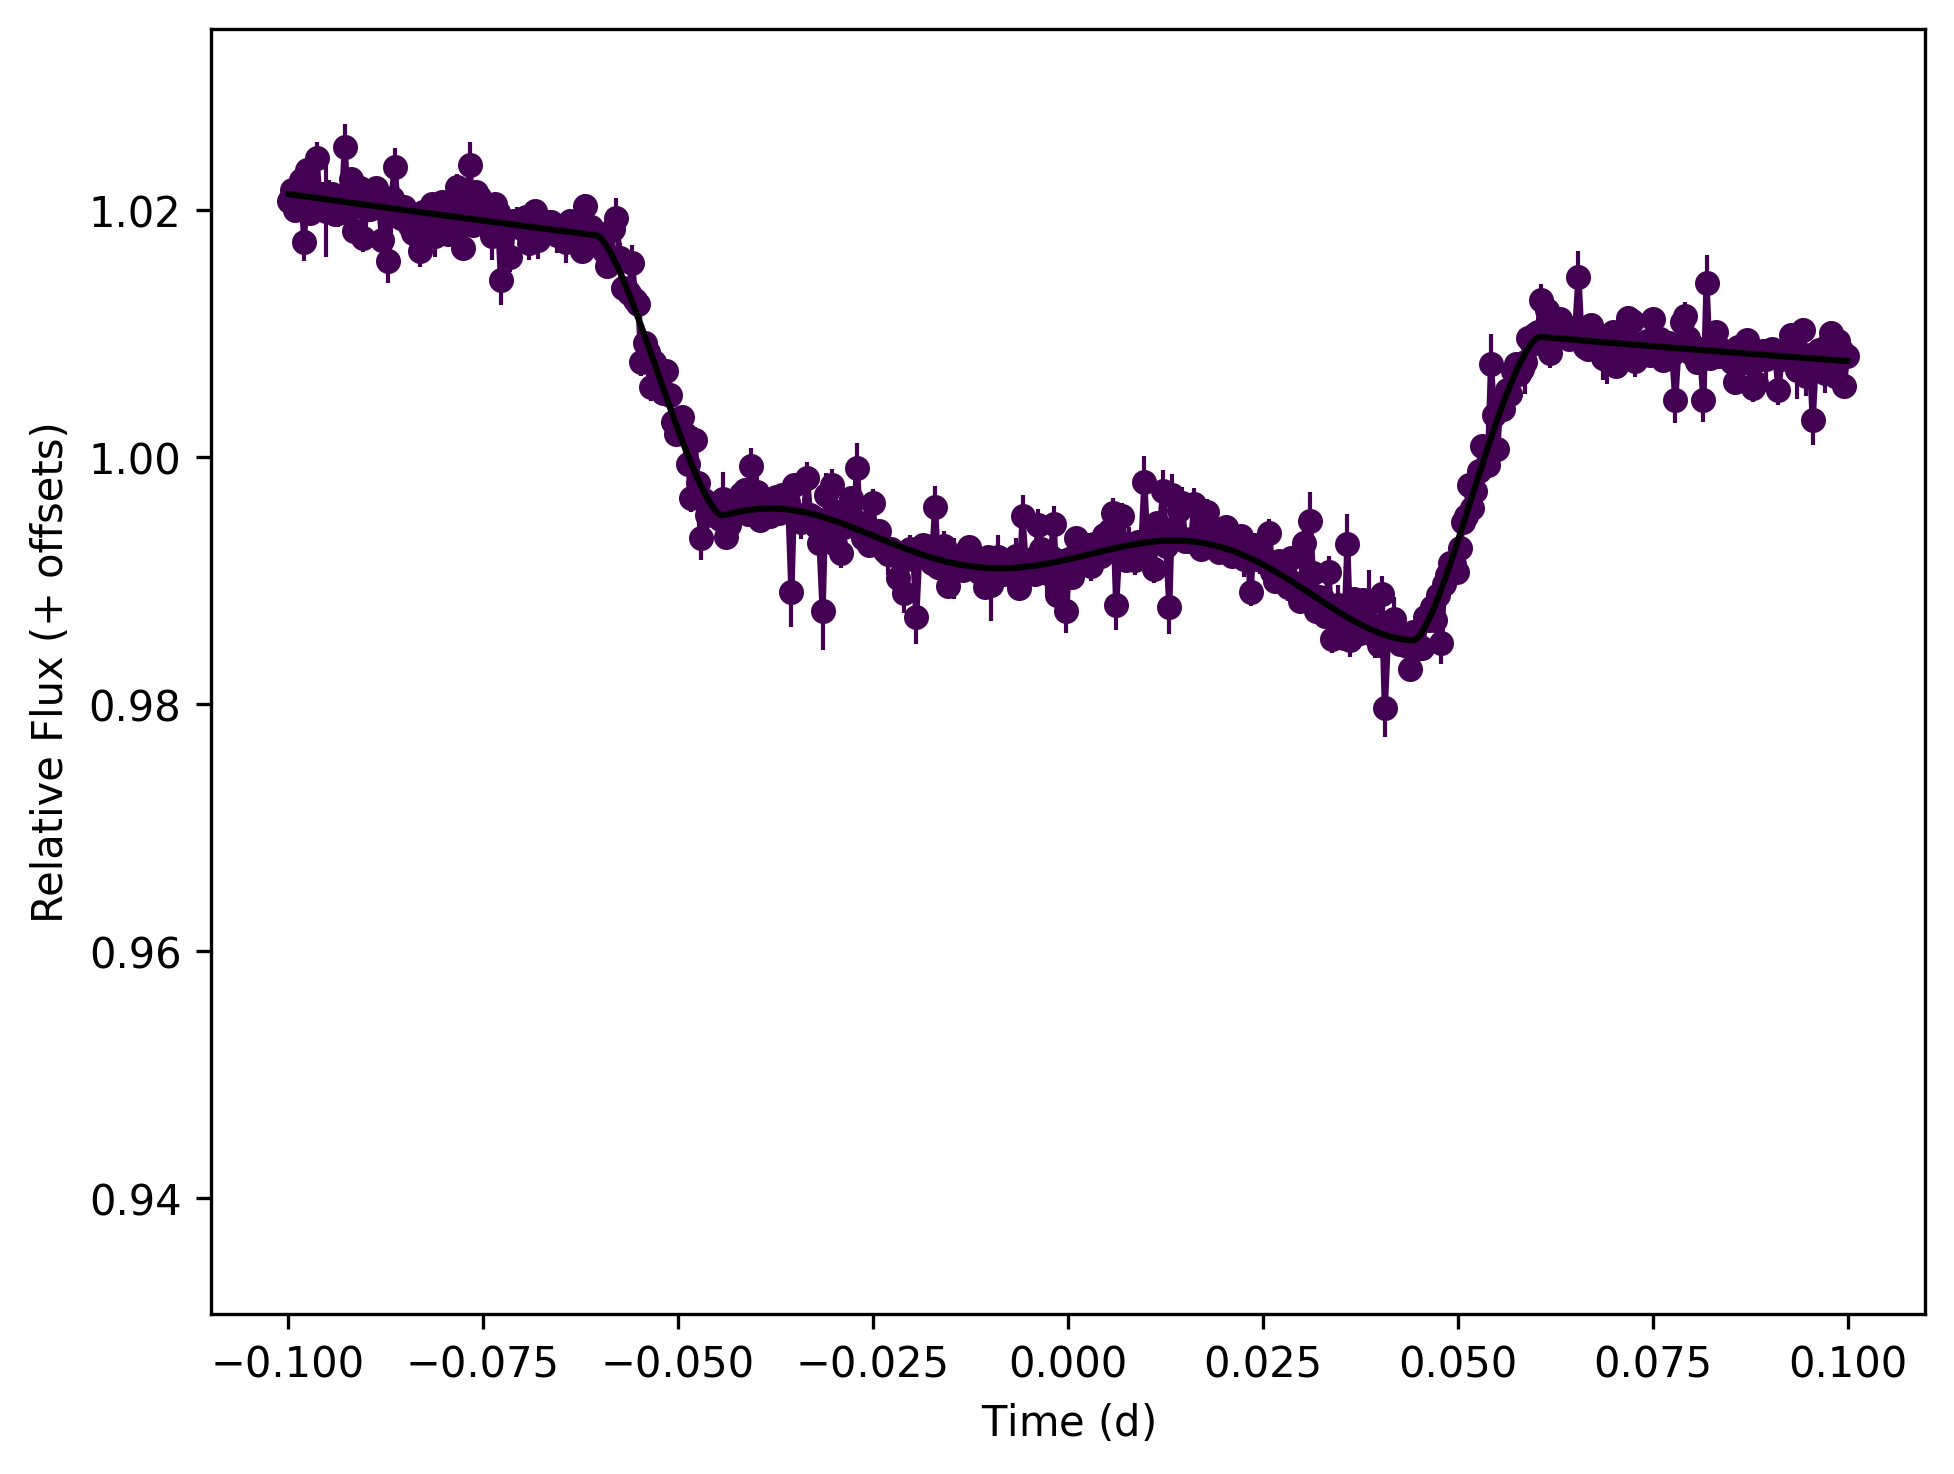

In [136]:
s.plot_lightcurves(text=False)

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0


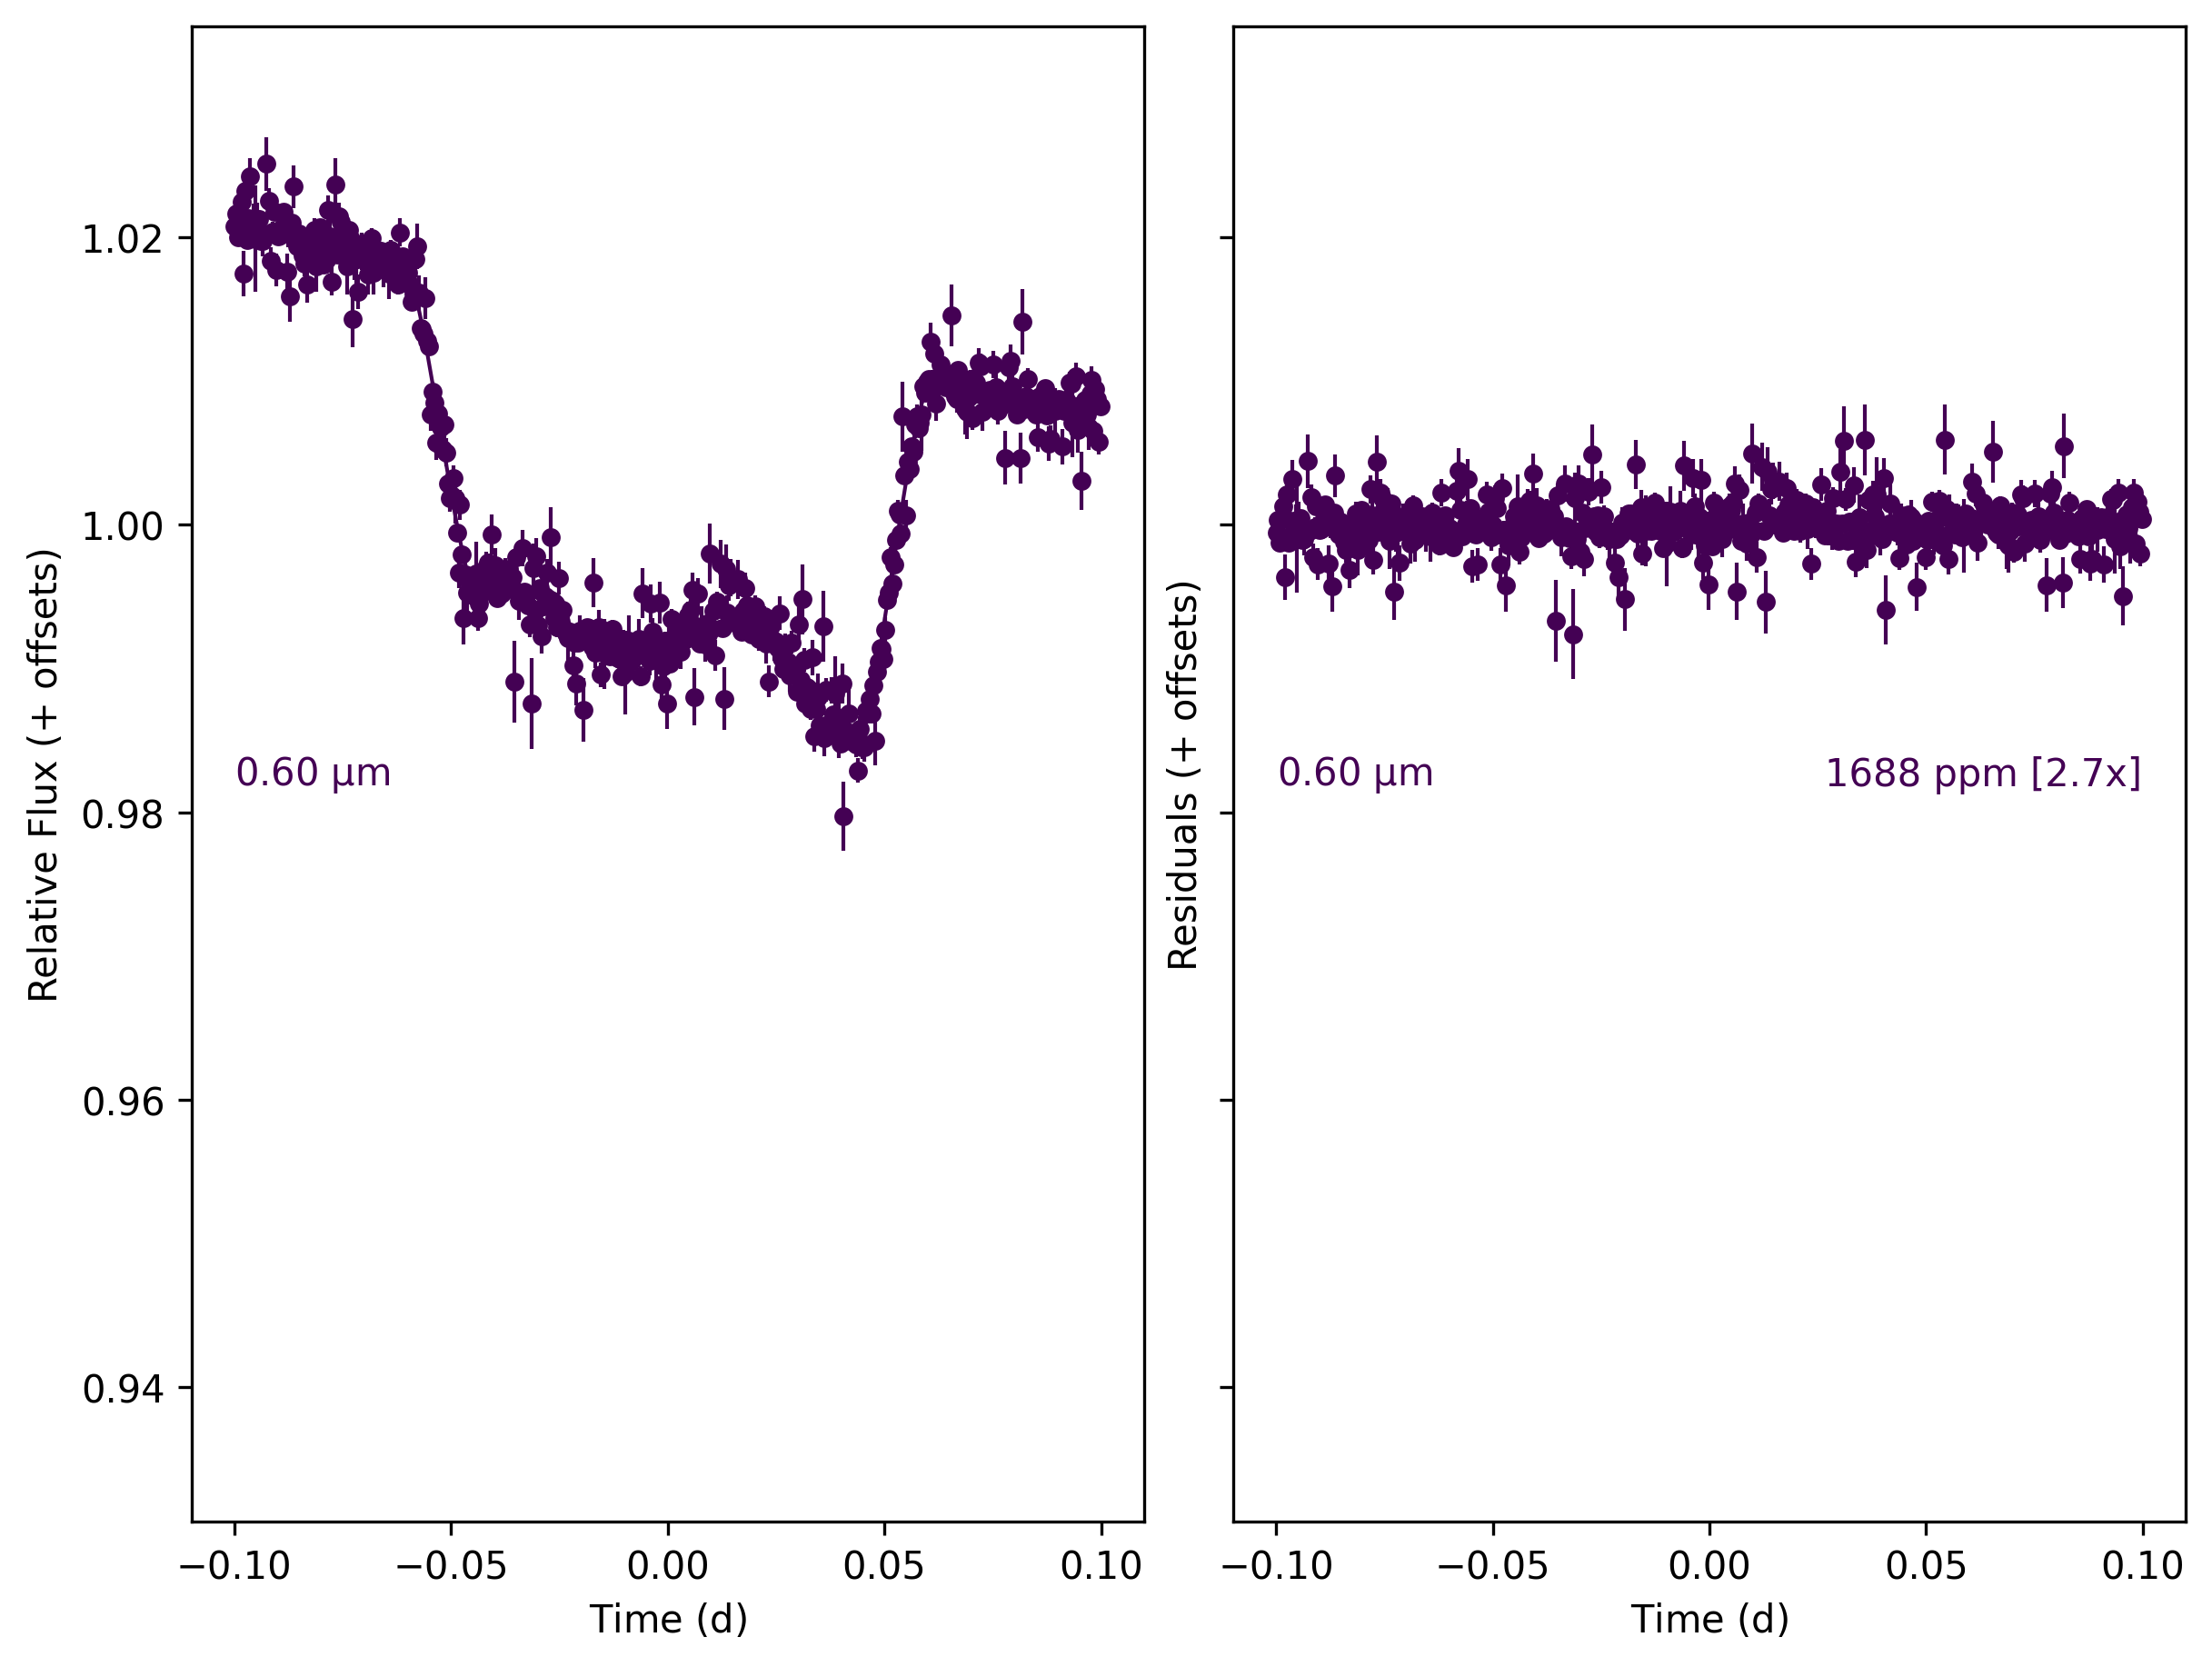

In [137]:
s.plot_with_model_and_residuals(histogram=False)

🌈🤖 'systematics_model' doesn't exist and will be skipped.



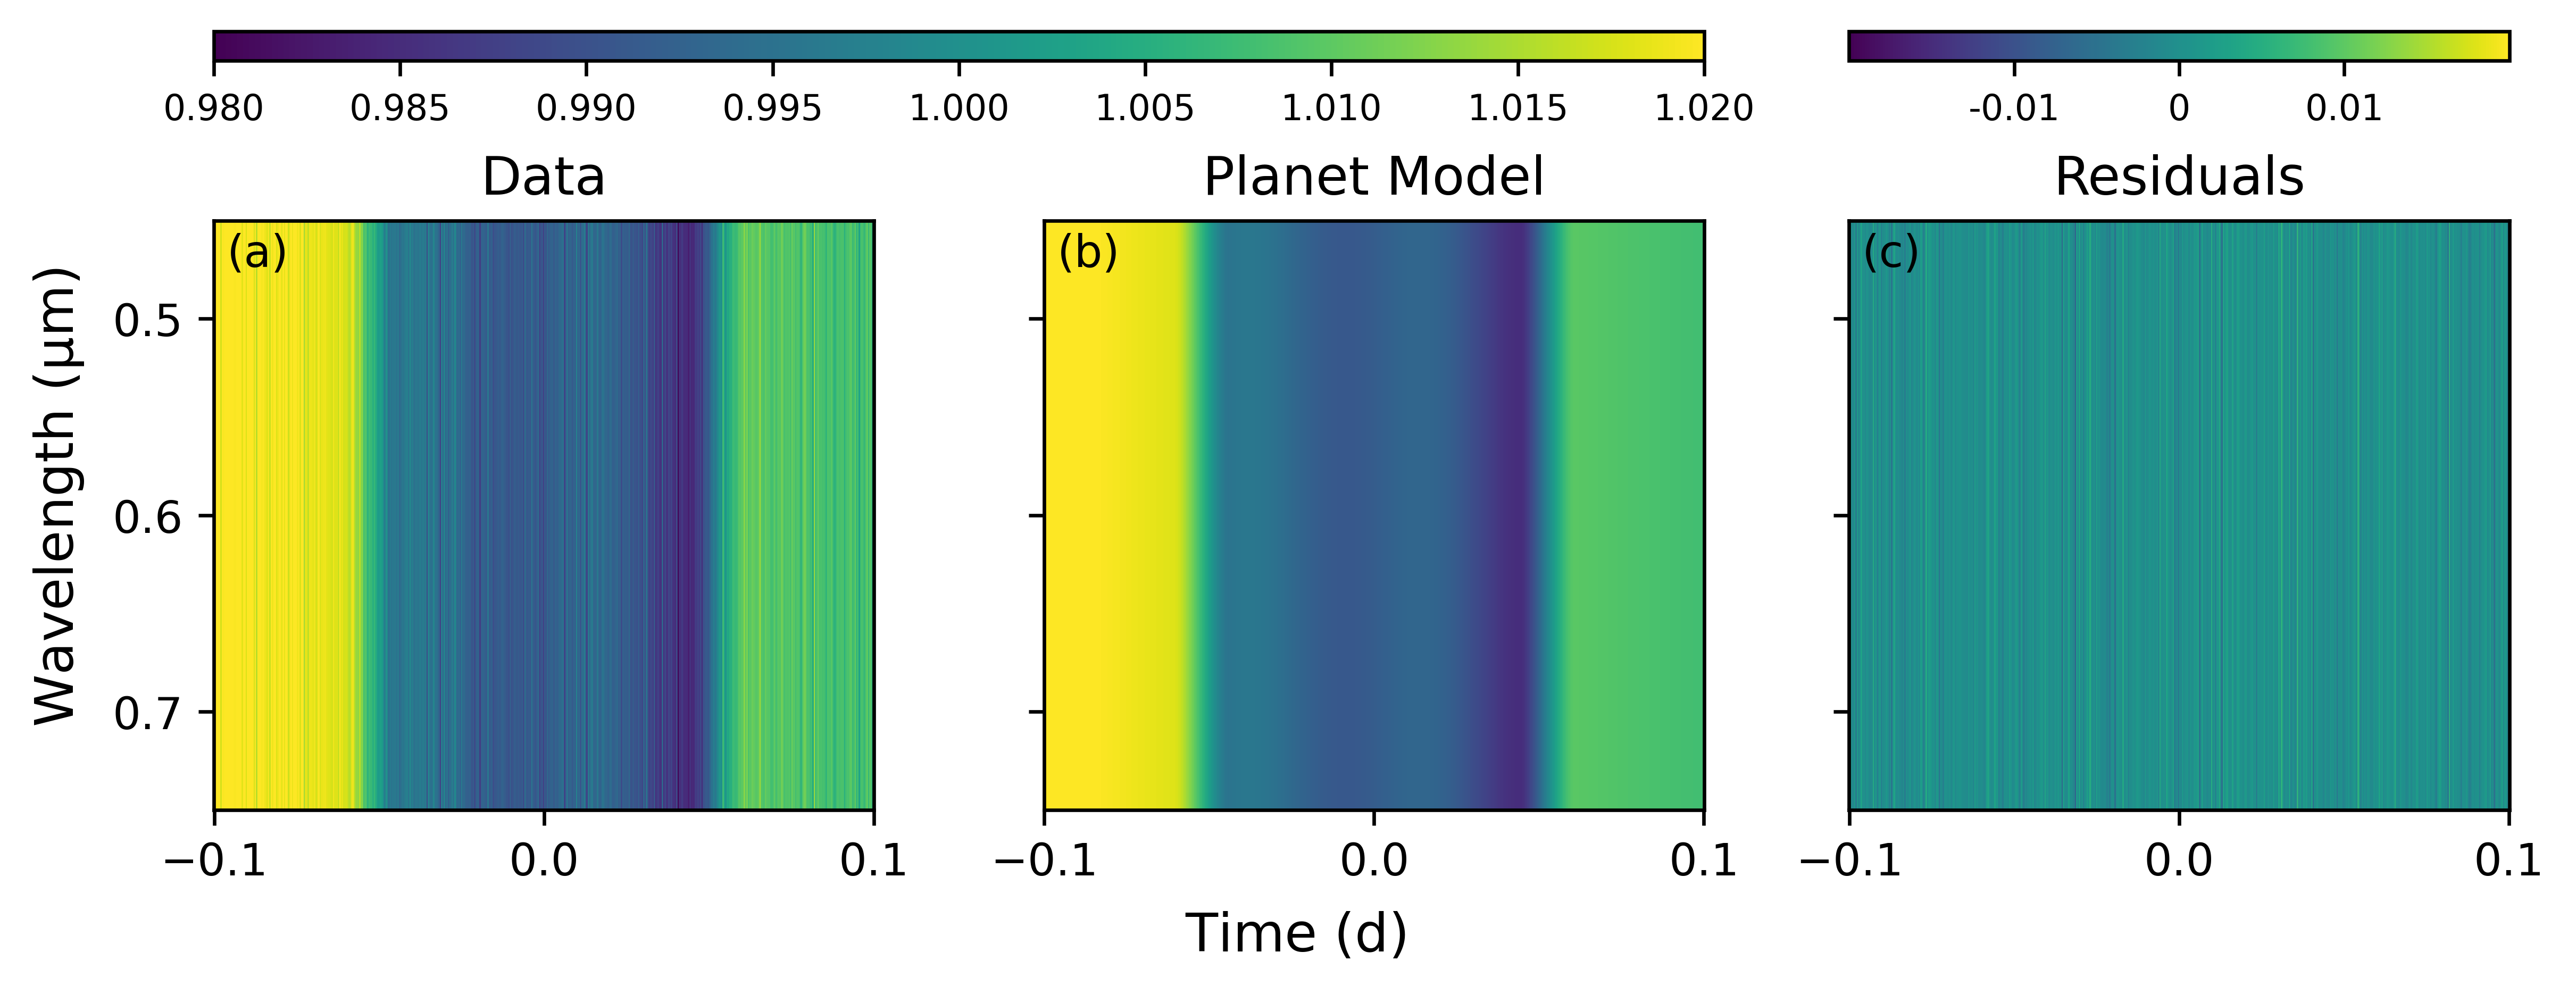

In [138]:
s.imshow_with_models()

In [139]:
s.show(t=s.data.time)

In [149]:
import arviz as az
with s._pymc3_model:
    print(az.summary(s.trace), az.summary(s.trace, stat_focus = "median"))

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
arviz - WARN

                                   mean     sd  hdi_3%  hdi_97%  mcse_mean  \
transitspot_A[0]                  1.143  0.001   1.142    1.144      0.000   
transitspot_rp[0]                 5.012  0.003   5.008    5.018      0.000   
transitspot_t0[0]                 0.000  0.000   0.000    0.000      0.000   
transitspot_u[0, 0]               0.050  0.003   0.046    0.057      0.001   
transitspot_u[0, 1]               0.159  0.006   0.148    0.168      0.002   
transitspot_spot_1_radius[0]     19.739  0.083  19.576   19.882      0.007   
transitspot_spot_1_latitude[0]   -1.226  0.221  -1.610   -0.805      0.039   
transitspot_spot_1_longitude[0]  14.384  0.067  14.256   14.509      0.006   
transitspot_spot_2_radius[0]     25.786  0.032  25.734   25.852      0.003   
transitspot_spot_2_latitude[0]   -7.824  0.150  -8.132   -7.570      0.013   
transitspot_spot_2_longitude[0] -40.386  0.115 -40.583  -40.179      0.012   

                                 mcse_sd  ess_bulk  ess_tail  r

In [151]:
s.summarize(stat_focus = "median", overwrite=True)

Summarize has already been run
                                      mean        sd    hdi_16%    hdi_84%  \
transitspot_A[0]                  1.143495  0.000514   1.143069   1.144076   
transitspot_rp[0]                 5.012466  0.002675   5.009395   5.014449   
transitspot_t0[0]                 0.000069  0.000013   0.000056   0.000082   
transitspot_u[0, 0]               0.049579  0.003073   0.046439   0.052468   
transitspot_u[0, 1]               0.158935  0.005885   0.152640   0.164727   
transitspot_spot_1_radius[0]     19.739083  0.083206  19.655970  19.822054   
transitspot_spot_1_latitude[0]   -1.226105  0.221201  -1.480924  -1.078405   
transitspot_spot_1_longitude[0]  14.383871  0.066729  14.331256  14.460290   
transitspot_spot_2_radius[0]     25.786229  0.032095  25.747460  25.809776   
transitspot_spot_2_latitude[0]   -7.824339  0.149756  -7.997049  -7.712934   
transitspot_spot_2_longitude[0] -40.386330  0.114612 -40.519810 -40.288623   

                                